# Titanic Dataset
**Michał M.**

## Introduction
This is my first kernel at Kaggle. I choosed the Titanic competition, it is well known, I just wanted to train my python skills, as I am advenced R user, but have minor experience with python.

This script follows three main parts:

* Feture analysis
* Feature engineering
* Modeling

%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing


sns.set_style('whitegrid')

## Data load and initial checks

### Data import

In [116]:
# load data
train = pd.read_csv("./01 Data/train.csv")
test  = pd.read_csv("./01 Data/test.csv")

# preview
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Joining train and test set

In [117]:
# join train and test datasets in order to obtain the same number of features

train_len = len(train)
full_dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### NULL and missing values

In [118]:
# fill empty and Nan's values with NaN
dataset = full_dataset.fillna(np.nan)

# null values
dataset.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
Parch             0
SibSp             0
Sex               0
Name              0
Pclass            0
PassengerId       0
dtype: int64

In [119]:
train.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [120]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There is a lot missing values in the **cabin** column (almost 80%), what probably will make it hard to use.

## Feature analysis

### Numerical variables

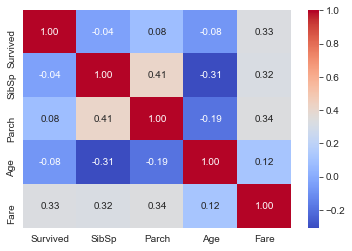

In [163]:
# correlation matrix
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt = ".2f", cmap = "coolwarm")

#### SibSp

*number of siblings/spouses aboard the Titanic*

The dataset defines family relations in this way:
 * Sibling = brother, sister, stepbrother, stepsister;
 * Spouse = husband, wife (mistresses and fiancés were ignored).

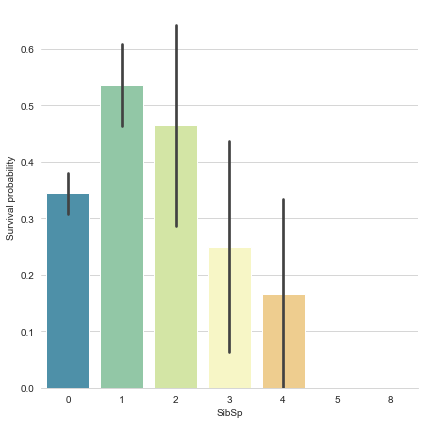

In [122]:
# SibSp vs Survived
p = sns.catplot(x="SibSp", y="Survived", data=train, kind="bar", height = 6, palette="Spectral_r")
p.despine(left=True)
p = p.set_ylabels("Survival probability")

Seems that that higher number of siblings/spouses decrease the chance of survival.

#### Parch

*number of parents/children aboard the Titanic*

The dataset defines family relations in this way:
 * Parent = mother, father;
 * Child = daughter, son, stepdaughter, stepson.
 
Some children travelled only with a nanny, therefore parch=0 for them.

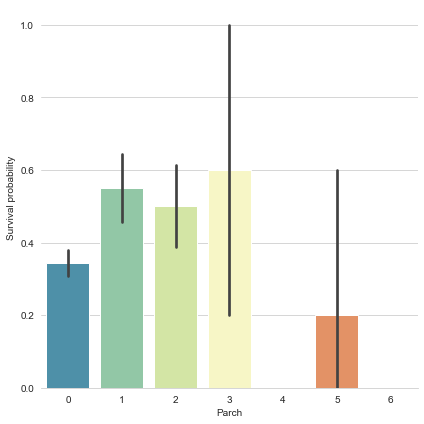

In [123]:
# Parch vs Survived
p = sns.catplot(x="Parch", y="Survived", data=train, kind="bar", height = 6, palette="Spectral_r")
p.despine(left=True)
p = p.set_ylabels("Survival probability")

#### Age

*Age in years*

Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

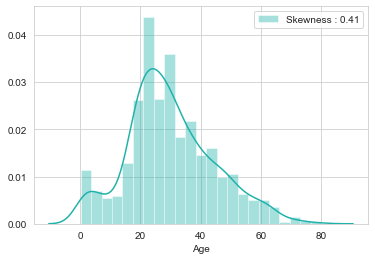

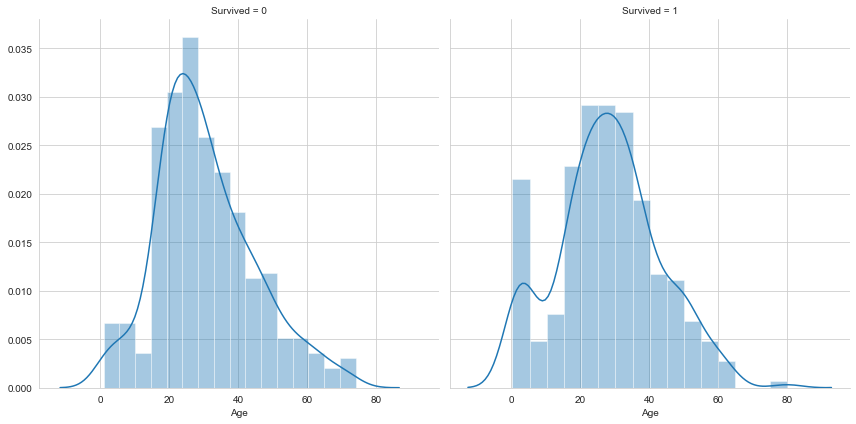

In [124]:
# Age distribution
p = sns.distplot(dataset["Age"], color="LightSeaGreen", label="Skewness : %.2f"%(dataset["Age"].skew()))
p = p.legend(loc="best")

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, "Age")

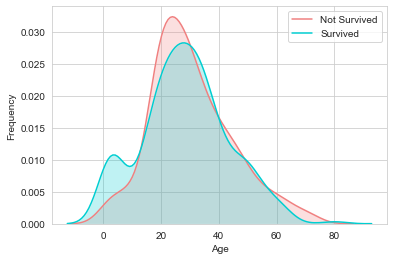

In [125]:
# comparison on single plot
p = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="lightcoral", shade=True)
p = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=p, color="darkturquoise", shade=True)
p.set_xlabel("Age")
p.set_ylabel("Frequency")
p = p.legend(["Not Survived","Survived"])

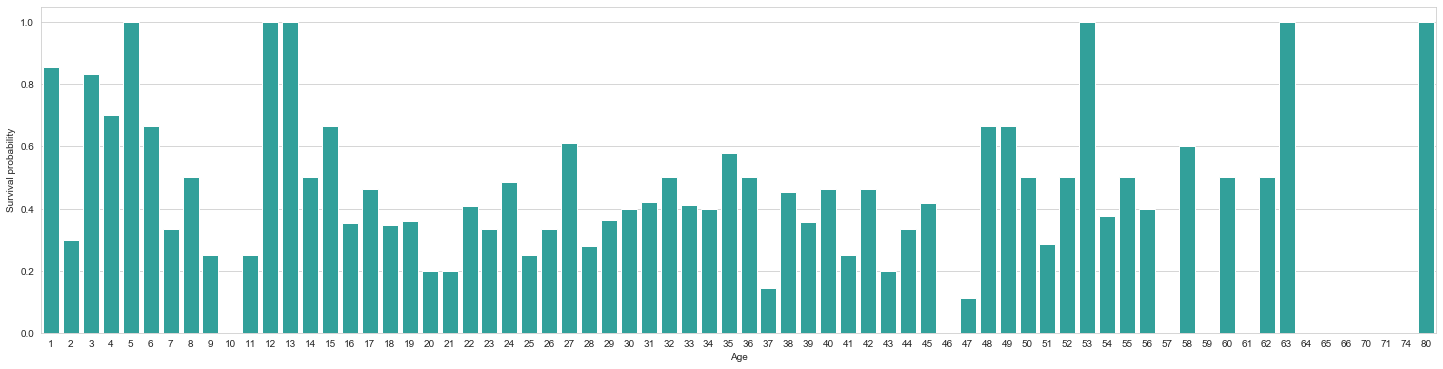

In [126]:
plt.figure(figsize=(25,6))

avg_survival_by_age = train[["Age", "Survived"]].apply(np.ceil).groupby(['Age'], as_index=False).mean()
avg_survival_by_age[["Age"]] = avg_survival_by_age[["Age"]].astype(int)
p = sns.barplot(x='Age', y='Survived', data=avg_survival_by_age, color="LightSeaGreen")
p = p.set_ylabel("Survival probability")

#### Fare

*Passenger fare*

Remeber, there was one observation with `Null` value in the **Fare** column.

In [127]:
dataset["Fare"].isnull().sum()

1

We will fill it with median value of the column.

In [128]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

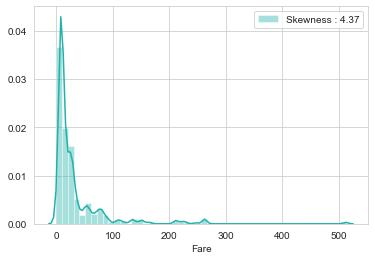

In [129]:
# Fare distribution over whole data
p = sns.distplot(dataset["Fare"], color="LightSeaGreen", label="Skewness : %.2f"%(dataset["Fare"].skew()))
p = p.legend(loc="best")

Fare distribution is very skewed, we tried to *unskew* it usin logarithm function

In [130]:
# log function on Fare to reduce skewness
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
train["Fare"] = train["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
test["Fare"] = test["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

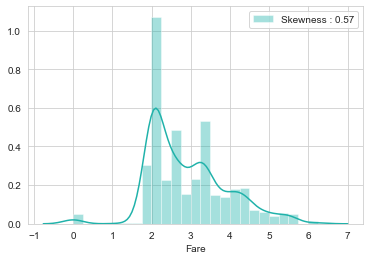

In [131]:
p = sns.distplot(dataset["Fare"], color="LightSeaGreen", label="Skewness : %.2f"%(dataset["Fare"].skew()))
p = p.legend(loc="best")

After tranformation it looks much better, no other modifications are curently needed. Let plot *Fare* variable and its distribution wrt survival.

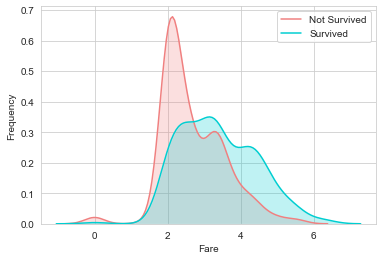

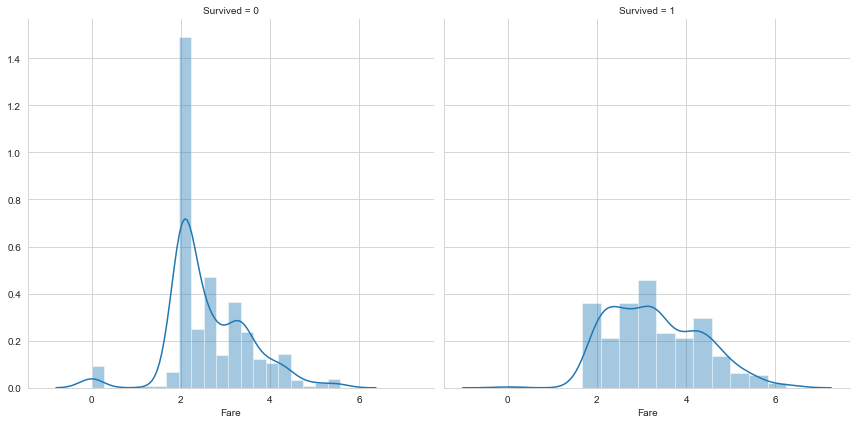

In [137]:
# comparison on single plot
p = sns.kdeplot(train["Fare"][(train["Survived"] == 0) & (train["Age"].notnull())], color="lightcoral", shade=True)
p = sns.kdeplot(train["Fare"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=p, color="darkturquoise", shade=True)
p.set_xlabel("Fare")
p.set_ylabel("Frequency")
p = p.legend(["Not Survived","Survived"])

# Age vs Survived
p = sns.FacetGrid(train, col='Survived', height = 6)
p = p.map(sns.distplot, "Fare")

There is slight, visible diffrence beetween distributions.

### Categorical Variables

Now we proceed to categorical variables and their distribution with relation to variable *Survived*

#### Sex

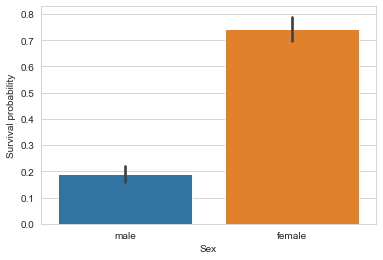

In [138]:
p = sns.barplot(x="Sex" ,y="Survived", data=train)
p = p.set_ylabel("Survival probability")

It is visible, that **sex** play import role in survival of the underlying passenger. 

In [139]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


#### Pclass

*Ticket class*

A proxy for socio-economic status (SES):
 * 1st = Upper
 * 2nd = Middle
 * 3rd = Lower

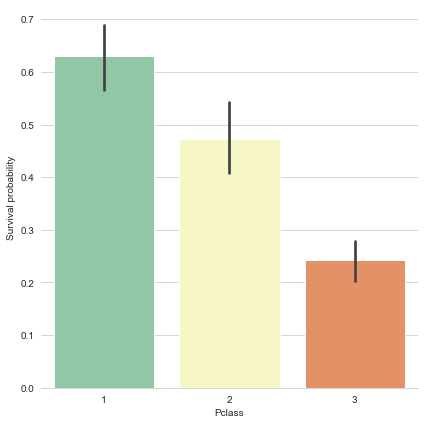

In [156]:
# Pclass vs Survived
p = sns.catplot(x="Pclass", y="Survived", data=train, kind="bar", height=6 , palette="Spectral_r")
p.despine(left=True)
p = p.set_ylabels("Survival probability")

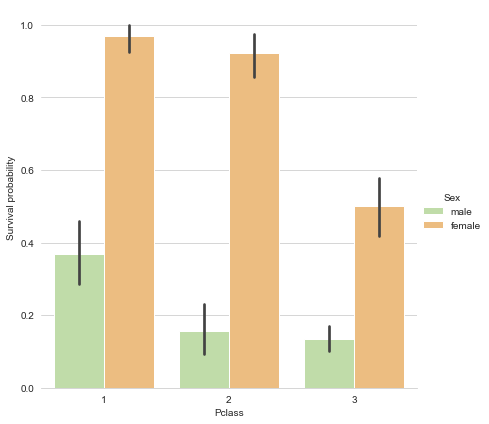

In [151]:
# Pclass vs Survived vs Sex
p = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, height=6, kind="bar", palette="Spectral_r")
p.despine(left=True)
p = p.set_ylabels("Survival probability")

#### Embarked

*Port of Embarkation*

A port of embarkation coded as:
 * C = Cherbourg;
 * Q = Queenstown;
 * S = Southampton.
 
 
 There we two observations with `Null` value in the **Embarked** column.

In [153]:
dataset["Embarked"].isnull().sum()

2

We filled it with most common value, i.e. 'S'.

In [155]:
dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].mode())

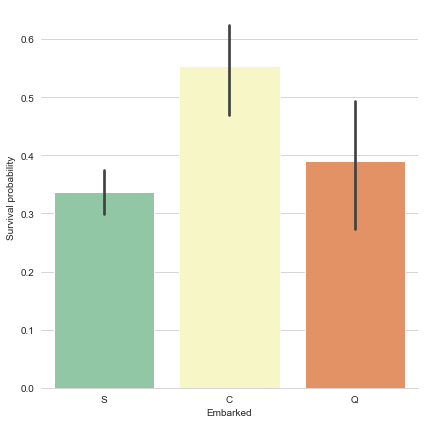

In [157]:
# Embarked vs Survived
p = sns.catplot(x="Embarked", y="Survived", data=train, kind="bar", height=6 , palette="Spectral_r")
p.despine(left=True)
p = p.set_ylabels("Survival probability")

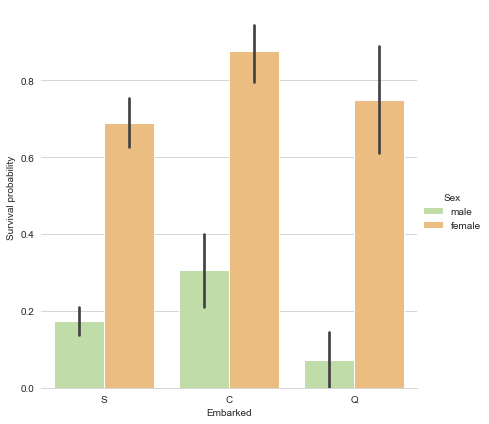

In [160]:
# Embarked vs Survived vs Sex
p = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=train, height=6, kind="bar", palette="Spectral_r")
p.despine(left=True)
p = p.set_ylabels("Survival probability")

It seems that passenger coming from Cherbourg have more chance to survive.

Let's check proportion of classes among all three ports.

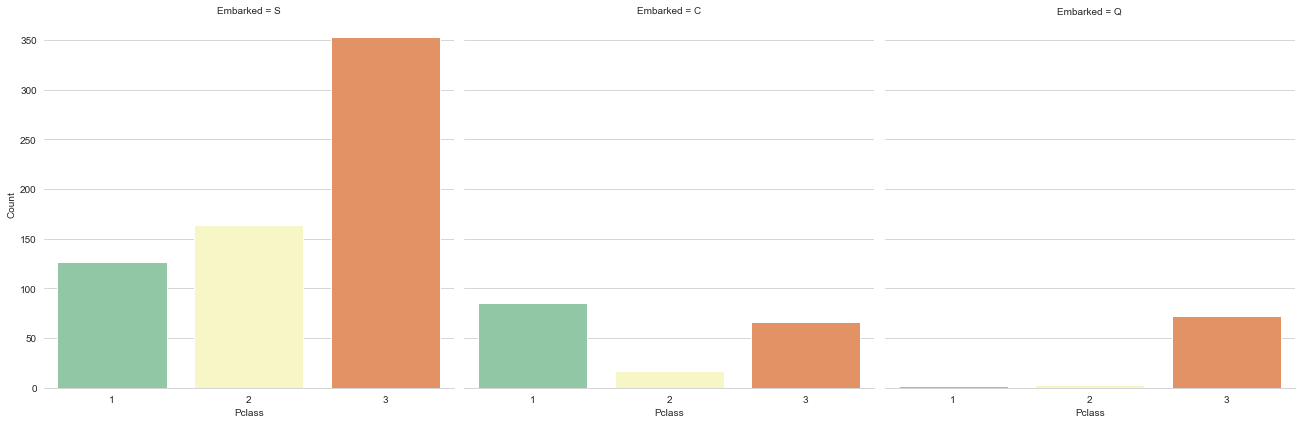

In [168]:
# Pclass vs Embarked 
g = sns.catplot("Pclass", col="Embarked", data=train, height=6, kind="count", palette="Spectral_r")
g.despine(left=True)
g = g.set_ylabels("Count")

We can conclude that the third class is the most frequent for passenger coming from Southampton and Queenstown, whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

We can't explain why first class has an higher survival rate. Probably first class passengers were prioritised during the evacuation due to their influence.